In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.behavioral_utils as behavioral_utils

import os
import pandas as pd
import matplotlib

from sklearn.linear_model import LinearRegression

EVENT = "FeedbackOnset"  # event in behavior to align on
PRE_INTERVAL = 1300   # time in ms before event
POST_INTERVAL = 1500  # time in ms after event
INTERVAL_SIZE = 100  # size of interval in ms

SESS_BEHAVIOR_PATH = "/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"
SESS_SPIKES_PATH = "/data/patrick_scratch/multi_sess/{sess_name}/{sess_name}_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins.pickle"

feature_dims = ["Color", "Shape", "Pattern"]

rule_to_dim = {
    'CIRCLE': 'Shape', 
    'SQUARE': 'Shape', 
    'STAR': 'Shape', 
    'TRIANGLE': 'Shape', 
    'CYAN': 'Color', 
    'GREEN': 'Color', 
    'MAGENTA': 'Color', 
    'YELLOW': 'Color', 
    'ESCHER': 'Pattern', 
    'POLKADOT': 'Pattern', 
    'RIPPLE': 'Pattern', 
    'SWIRL': 'Pattern'
}

In [10]:
session = "20180802"
model_path = f"/data/082023_Feat_RLDE_HV/sess-{session}_hv.csv"
model_vals = pd.read_csv(model_path)
feat_names = np.array([
    'CIRCLE', 'SQUARE', 'STAR', 'TRIANGLE', 
    'CYAN', 'GREEN', 'MAGENTA', 'YELLOW', 
    'ESCHER', 'POLKADOT', 'RIPPLE', 'SWIRL'
])
renames = {}
for i, feat_name in enumerate(feat_names):
    renames[f"feat_{i}"] = feat_name
model_vals = model_vals.rename(columns=renames)

In [11]:
behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
beh = pd.read_csv(behavior_path)
# filter trials 
valid_beh = behavioral_utils.get_valid_trials(beh)
spikes_path = SESS_SPIKES_PATH.format(
    sess_name=session, 
    pre_interval=PRE_INTERVAL, 
    event=EVENT, 
    post_interval=POST_INTERVAL, 
    interval_size=INTERVAL_SIZE
)
frs = pd.read_pickle(spikes_path)

# grab the features of the selected card
feature_selections = behavioral_utils.get_selection_features(valid_beh)
valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
valid_beh_vals = pd.merge(valid_beh, model_vals, left_on="TrialNumber", right_on="trial", how="inner")
assert(len(valid_beh_vals) == len(valid_beh))

In [12]:
valid_beh_vals

,TrialNumber,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,CurrentRule,LastRule,...,STAR,TRIANGLE,CYAN,GREEN,MAGENTA,YELLOW,ESCHER,POLKADOT,RIPPLE,SWIRL
0,35,2,0,NaN,641,Incorrect,3.0,8,CIRCLE,CYAN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,36,2,1,NaN,627,Incorrect,3.0,8,CIRCLE,CYAN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,37,2,2,NaN,808,Incorrect,3.0,8,CIRCLE,CYAN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,38,2,3,NaN,783,Incorrect,1.0,8,CIRCLE,CYAN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,39,2,4,NaN,1116,Incorrect,1.0,8,CIRCLE,CYAN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1702,1738,54,31,NaN,4072,Correct,0.0,7,GREEN,CYAN,...,0.007635,0.218069,-0.017239,0.540891,-0.000036,-0.131027,0.193760,0.032039,0.110023,0.196207
1703,1739,54,32,NaN,4429,Correct,0.0,7,GREEN,CYAN,...,0.007359,0.245983,-0.016615,0.568805,-0.000035,-0.126286,0.186749,0.030880,0.137937,0.189108
1704,1740,54,33,NaN,4457,Correct,0.0,7,GREEN,CYAN,...,0.057369,0.237082,-0.016014,0.618815,-0.000034,-0.121716,0.179992,0.029762,0.132946,0.239118
1705,1741,54,34,NaN,4380,Correct,0.0,7,GREEN,CYAN,...,0.075414,0.228504,-0.015434,0.636860,-0.000033,-0.117312,0.173479,0.028685,0.128135,0.257163


In [13]:
def calc_baseline(beh, feature):
    # what is baseline if we just averaged values when the feature is selected, vs. when note selected
    feature_dim = rule_to_dim[feature]
    selected = beh[beh[feature_dim] == feature]
    not_selected = beh[beh[feature_dim] != feature]
    beh.loc[beh[feature_dim] == feature, f"pred_{feature}_val"] = selected[feature].mean()
    beh.loc[beh[feature_dim] != feature, f"pred_{feature}_val"] = not_selected[feature].mean()
    mse = np.mean((beh[f"pred_{feature}_val"] - beh[feature]) ** 2)
    return 1 - mse / np.var(beh[feature])

In [14]:
frs = frs[frs.TrialNumber.isin(valid_beh.TrialNumber)]
frs = frs.rename(columns={"SpikeCounts": "Value"})

In [15]:
label = model_vals.TRIANGLE.values

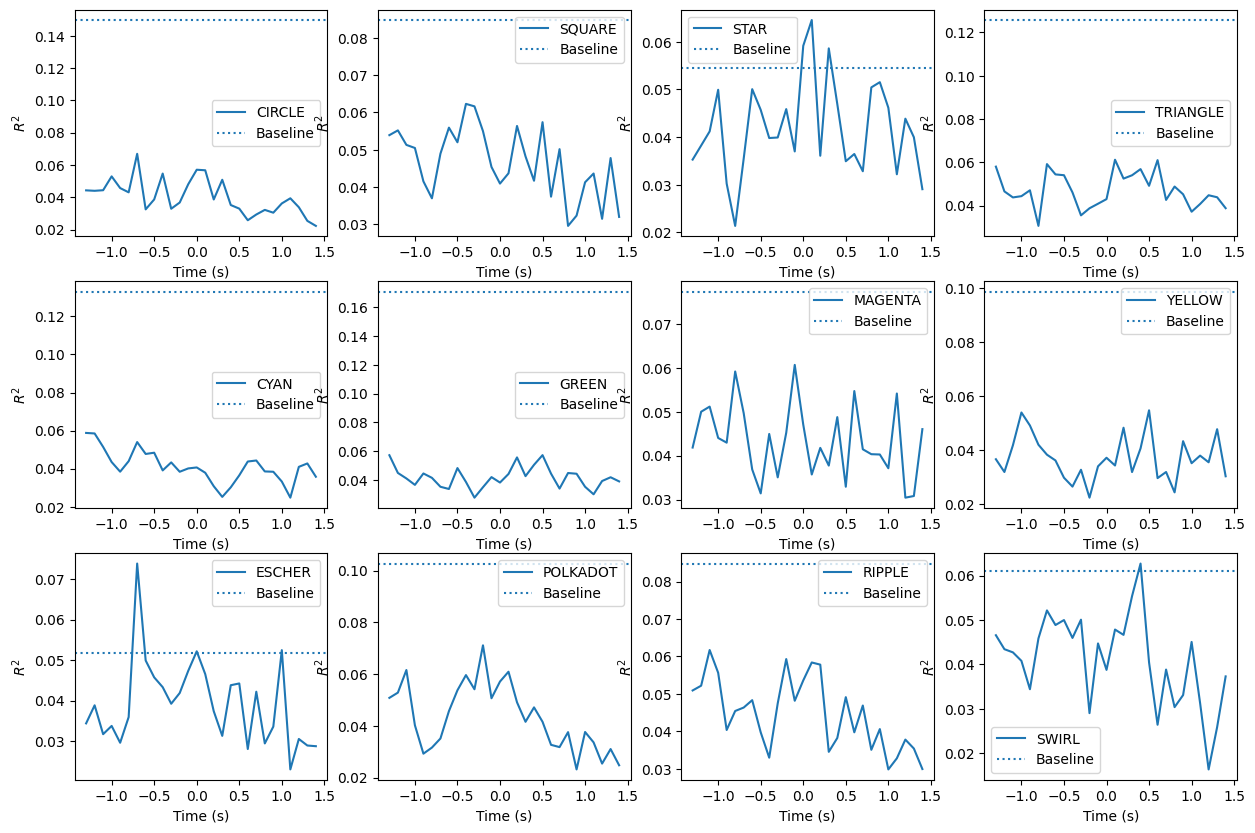

In [18]:
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
for i, feat_name in enumerate(feat_names):
    ax = axs[int(i / 4), i % 4]
    labels = valid_beh_vals[feat_name].values
    baseline_score = calc_baseline(valid_beh_vals, feat_name)
    scores = []
    for time_bin in frs.TimeBins.unique():
        fr_time = frs[np.isclose(frs.TimeBins, time_bin)]
        inputs = classifier_utils.transform_to_input_data(fr_time)
        lr = LinearRegression().fit(inputs, labels)
        score = lr.score(inputs, labels)
        scores.append(score)
    ax.plot(frs.TimeBins.unique() - 1.3, scores, label=feat_name)
    ax.axhline(baseline_score, linestyle="dotted", label="Baseline")
    ax.legend()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("$R^2$")

In [11]:
inputs.shape

(1707, 46)

In [3]:
renames = {}
for i, feat_name in enumerate(feat_names):
    renames[f"feat_{i}"] = feat_name

In [4]:
model_vals = model_vals.rename(columns=renames)

In [11]:
behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
beh = pd.read_csv(behavior_path)

# filter trials 
valid_beh = behavioral_utils.get_valid_trials(beh)

# grab the features of the selected card
feature_selections = behavioral_utils.get_selection_features(valid_beh)
valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
valid_beh_vals = pd.merge(valid_beh, model_vals, left_on="TrialNumber", right_on="trial", how="inner")
assert(len(valid_beh_vals) == len(valid_beh))

In [14]:
def get_highest_val_feature(row):
    highest_val_feat = None
    highest_val = -1
    for feature_dim in feature_dims:
        feature = row[feature_dim]
        val = row[feature]
        if val > highest_val:
            highest_val_feat = feature
    row["highest_val_feature"] = highest_val_feat
    return row
beh_vals = valid_beh_vals.apply(get_highest_val_feature, axis=1)

In [15]:
beh_vals

,TrialNumber,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,CurrentRule,LastRule,...,TRIANGLE,CYAN,GREEN,MAGENTA,YELLOW,ESCHER,POLKADOT,RIPPLE,SWIRL,highest_val_feature
0,35,2,0,NaN,641,Incorrect,3.0,8,CIRCLE,CYAN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ESCHER
1,36,2,1,NaN,627,Incorrect,3.0,8,CIRCLE,CYAN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,POLKADOT
2,37,2,2,NaN,808,Incorrect,3.0,8,CIRCLE,CYAN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,SWIRL
3,38,2,3,NaN,783,Incorrect,1.0,8,CIRCLE,CYAN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ESCHER
4,39,2,4,NaN,1116,Incorrect,1.0,8,CIRCLE,CYAN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,POLKADOT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1702,1738,54,31,NaN,4072,Correct,0.0,7,GREEN,CYAN,...,0.218069,-0.017239,0.540891,-0.000036,-0.131027,0.193760,0.032039,0.110023,0.196207,RIPPLE
1703,1739,54,32,NaN,4429,Correct,0.0,7,GREEN,CYAN,...,0.245983,-0.016615,0.568805,-0.000035,-0.126286,0.186749,0.030880,0.137937,0.189108,SWIRL
1704,1740,54,33,NaN,4457,Correct,0.0,7,GREEN,CYAN,...,0.237082,-0.016014,0.618815,-0.000034,-0.121716,0.179992,0.029762,0.132946,0.239118,SWIRL
1705,1741,54,34,NaN,4380,Correct,0.0,7,GREEN,CYAN,...,0.228504,-0.015434,0.636860,-0.000033,-0.117312,0.173479,0.028685,0.128135,0.257163,RIPPLE
